# Geopandas Choropleths

## Introduction

 I was working my way through "Regression and Other Stories", by 
Andrew Gelman, Jennifer Hill, Aki Vehtari, with the intent to see if I could 
use Python to perform the examples they provide in R.

One of the exercises was to analyse Human Development Index (HDI) data for the individual staters of the USA.
There was ininteresting use of rank scatterplots to visualize relationships betwen income and HDI.

The data concept with turned out to be largely bogus, being an imprecise proxy for average stage income. However,
R was used to create a Choropleth to reproduce an map in the original article.  

So I thought, how would I do that in Python?  I have recently upgraded to Python 3.8, so this would be a good
opportunity to learn the new features of my favourite packages.

## Strategy

My first thought was to use Geopandas.  Geoplot has some nice graphics, but Geopandas can create choropleths quite easily.

----
## Implementation

In [3]:
import geopandas as gpd
import pandas as pd
import pathlib

import matplotlib.pyplot as plt

from cartopy import crs as ccrs

import os
import sys
import subprocess
import datetime
import platform
import datetime

In [4]:
%matplotlib inline

In [5]:
%load_ext watermark

In [6]:
%load_ext lab_black

----------
## Data Load and Cleanup

### HDI Data

The data was surprisingly untidy, and a bit of string hacking was needed to extract the data.  The Washington DC data row was dropped (not really a state).  The ```distance``` attribute turned out to distance from Canada.

In [7]:
path = pathlib.Path(
    'D:/RegressionGelman/ROS-Examples-master/HDI/data/hdi.dat'
)

hdi = pd.read_csv(
    path,
    sep='\t',
    skiprows=1,
    header=None,
    names=['rank', 'state', 'temp'],
)

hdi['hdi'] = hdi['temp'].str.slice(0, 4).astype(float)
hdi['distance'] = hdi['temp'].str.slice(5).astype(int)

hdi = hdi.drop(['temp'], axis=1)

hdi['state'] = hdi['state'].str.strip()
hdi2 = hdi[hdi['state'] != 'Washington, D.C.'].copy()

In [8]:
hdi2.head()

,rank,state,hdi,distance
0,1,Connecticut,0.962,2
1,2,Massachusetts,0.961,2
2,3,New Jersey,0.961,2
4,5,Maryland,0.960,3
5,6,Hawaii,0.959,2


### USA State Borders

I could have downloaded the Shapefile for USA state borders from the US Census (or other sites), but chose to use the ```Folium``` JSON dataset, mainly to get experience in GeoJSON files.  We can use Pandas to read this file.

In [12]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'

In [72]:
usa = pd.read_json(state_geo)

usa.head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'id': 'AL', 'properties': ..."
1,FeatureCollection,"{'type': 'Feature', 'id': 'AK', 'properties': ..."
2,FeatureCollection,"{'type': 'Feature', 'id': 'AZ', 'properties': ..."
3,FeatureCollection,"{'type': 'Feature', 'id': 'AR', 'properties': ..."
4,FeatureCollection,"{'type': 'Feature', 'id': 'CA', 'properties': ..."


The ```features``` attribute looks largely as expected.

In [71]:
usa['features'][0]

{'type': 'Feature',
 'id': 'AL',
 'properties': {'name': 'Alabama'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-87.359296, 35.00118],
    [-85.606675, 34.984749],
    [-85.431413, 34.124869],
    [-85.184951, 32.859696],
    [-85.069935, 32.580372],
    [-84.960397, 32.421541],
    [-85.004212, 32.322956],
    [-84.889196, 32.262709],
    [-85.058981, 32.13674],
    [-85.053504, 32.01077],
    [-85.141136, 31.840985],
    [-85.042551, 31.539753],
    [-85.113751, 31.27686],
    [-85.004212, 31.003013],
    [-85.497137, 30.997536],
    [-87.60028199999999, 30.997536],
    [-87.633143, 30.86609],
    [-87.408589, 30.674397],
    [-87.446927, 30.510088],
    [-87.37025, 30.427934],
    [-87.518128, 30.280057],
    [-87.655051, 30.247195],
    [-87.90699, 30.411504],
    [-87.934375, 30.657966],
    [-88.011052, 30.685351],
    [-88.10416, 30.499135],
    [-88.137022, 30.318396],
    [-88.394438, 30.367688],
    [-88.471115, 31.895754],
    [-88.241084, 33.796253],
    [-88.0986

Geopandas knows how to turn ```features``` into geometries.

In [16]:
usa_df = gpd.GeoDataFrame.from_features(usa['features'])

So we have a Geopandas dataframe, holding USA state borders by long USA state name

In [17]:
usa_df.head()

,geometry,name
0,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",Alabama
1,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691...",Alaska
2,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",Arizona
3,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",Arkansas
4,"POLYGON ((-123.23326 42.00619, -122.37885 42.0...",California


We do a quick and dirty plot to check the borders data.

<AxesSubplot:>

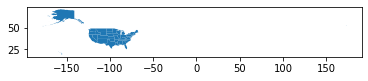

In [18]:
usa_df.plot()

-----------
### Linking HDI data to state borders

I maybe could have linked the two dataframe via state name (using Pandas magic), but chose to create a dict that allowed HDI looked, given state name.  I then created an HDI column from the state names in the ```usa_df``` dataframe, and added it to the dataframe. 

#### Create HDI table by state name

In [19]:
hdi_dict = {
    name: hdi
    for name, hdi in zip(hdi2['state'], hdi2['hdi'])
}

#### Create and add HDI column to dataframe

In [20]:
hdi_by_name = [hdi_dict[name] for name in usa_df['name']]
usa_df['hdi'] = hdi_by_name

#### Quick Choropleth Plot 
Do a quick sanity check that the data looks OK

<AxesSubplot:>

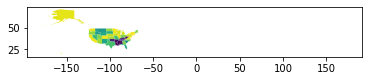

In [21]:
usa_df.plot(column='hdi')

------------
## Visualization

### Stage 1

We use the features of ```matplotlib``` to create a more appealing graphic.

- We set the plot limits to just show contiguous USA

- We use a monochrome color map

- We ask for a legend

- We use some ```Axes``` hackery to set the legend and map to be the same height

- We put titles on the legend and map

Text(0.5, 1.0, 'USA State HDI')

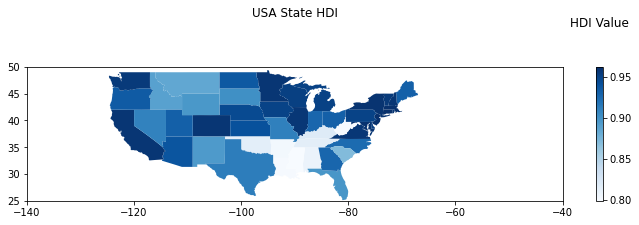

In [22]:
# Plot the data with a modified spatial extent
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_xlim((-140, -40))
ax.set_ylim((25, 50))

usa_df.plot(column='hdi', ax=ax, legend=True, cmap='Blues')

map_ax = fig.axes[0]
leg_ax = fig.axes[1]

map_box = map_ax.get_position()
leg_box = leg_ax.get_position()

leg_ax.set_position(
    [leg_box.x0, map_box.y0, leg_box.width, map_box.height]
)

leg_ax.set_title('HDI Value', pad=40)
map_ax.set_title('USA State HDI', pad=50)

We could also place the Legend below the map.

<AxesSubplot:>

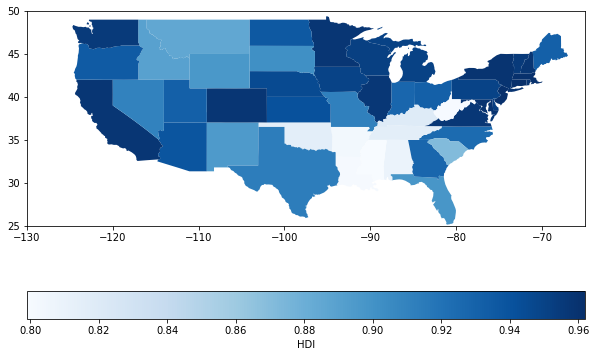

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.set_xlim((-130, -65))
ax.set_ylim((25, 50))

usa_df.plot(
    column='hdi',
    ax=ax,
    cmap='Blues',
    legend=True,
    legend_kwds={
        'label': "HDI",
        'orientation': "horizontal",
    },
)

------------
### Visualization Stage 2

I was a little unhappy with the maps above.  The usual map projection used for the USA contiguous states is an Albers Equal Area  (presumably because the USA is big enough that the Plate Carree distortions are noticable).
Also, the R code I am trying to emulate uses an equal area projection, using the Bonne Map Projection.  

```Cartopy``` to the rescue!  Well almost, because Cartopy doesn't support the Bonne Projection.  ESRI says 
    
    "Used during the 19th and early 20th centuries for atlas maps of Asia, Australia, Europe, and North America. Replaced with the Lambert Azimuthal Equal Area projection for continental mapping"
    
I don't know why the authors chose that projection.  Not to worry, there is an almost standard Projection EPSG:102003 I am going to use, as detailed below.

```
PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",
    GEOGCS["GCS_North_American_1983",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS_1980",6378137,298.257222101]],
        PRIMEM["Greenwich",0],
        UNIT["Degree",0.017453292519943295]],
    PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["False_Easting",0],
    PARAMETER["False_Northing",0],
    PARAMETER["longitude_of_center",-96],
    PARAMETER["Standard_Parallel_1",29.5],
    PARAMETER["Standard_Parallel_2",45.5],
    PARAMETER["latitude_of_center",37.5],
    UNIT["Meter",1],
    AUTHORITY["EPSG","102003"]]
    
```


### Cartopy
We create the projection in Cartopy that we wish to use for mapping

In [37]:
albo = ccrs.AlbersEqualArea(
    central_longitude=-96,
    central_latitude=37.5,
    false_easting=0.0,
    false_northing=0.0,
    standard_parallels=(29.5, 45.5),
    globe=None,
)

We have to set the Projection being used in our Lat/Lon coordinates as EPSG:4326 (Plate Carree)

In [43]:
usa_df2 = usa_df.set_crs(epsg=4326)

Check the CRS we have set on the Lat/Lon state border data

In [44]:
usa_df2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Convert the Lat/Lon data to Albers Projection data

In [47]:
usa_df2 = usa_df2.to_crs(albo.proj4_init)

Do a quick and dirty plot of the state borders using Geopandas (seems OK)

<AxesSubplot:>

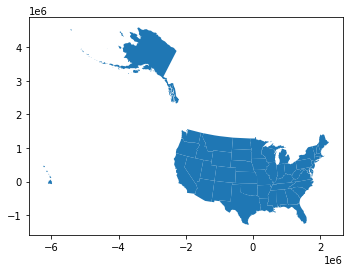

In [48]:
usa_df2.plot()

As an alternative to using Geopandas, we can use Cartopy to plot the geometric data in the Geopandas dataframe.
Not very enlightening, as it shows the whole globe by default.

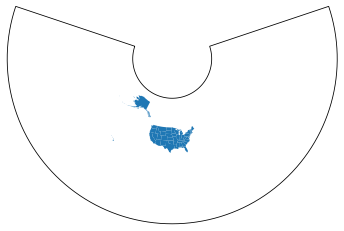

In [49]:
fig, ax = plt.subplots(subplot_kw={'projection': albo})
ax.add_geometries(usa_df2['geometry'], crs=albo)

We can constrain the plot to just the contiguous USA 

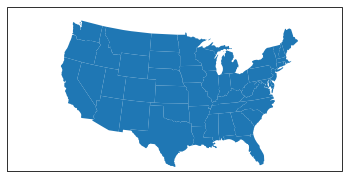

In [52]:
fig, ax = plt.subplots(subplot_kw={'projection': albo})

ax.set_extent([-130, -65, 25, 50], crs=ccrs.PlateCarree())
ax.add_geometries(usa_df2['geometry'], crs=albo)

Make the map a little larger

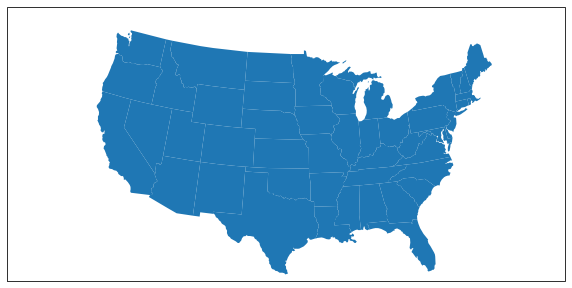

In [74]:
fig, ax = plt.subplots(
    subplot_kw={'projection': albo}, figsize=(10, 8)
)

ax.set_extent([-130, -65, 25, 50], crs=ccrs.PlateCarree())
ax.add_geometries(usa_df2['geometry'], crs=albo)

-------
## Final Result

We are now able to use Geopandas to produce our Choropleth, with the contiguous USA in a more familiar shape.  I used the ```viridis``` color map (Blue is sad, Yellow is happy).

Text(0.5, 1.0, 'USA HDI Gradient')

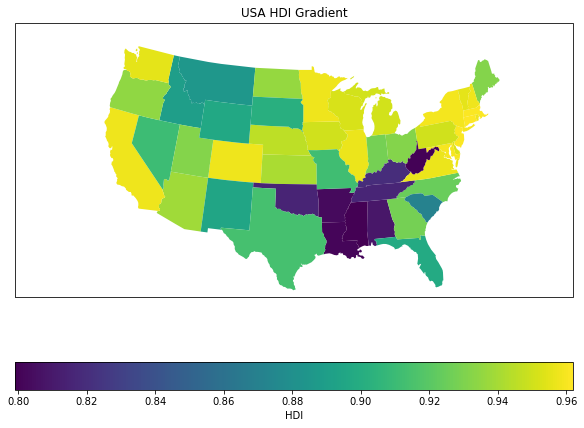

In [66]:
fig, ax = plt.subplots(
    subplot_kw={'projection': albo}, figsize=(10, 8)
)

ax.set_extent([-130, -65, 25, 50], crs=ccrs.PlateCarree())

usa_df2.plot(
    column='hdi',
    ax=ax,
    cmap='viridis',
    legend=True,
    legend_kwds={
        'label': "HDI",
        'orientation': "horizontal",
    },
)
ax.set_title('USA HDI Gradient')

-----------------
## Folium

Another way to get a choropleth in a more interactive map is to use Folium.

The data we have doesn't have state abbreviations, so add a column to fix this.

In [82]:
usa_df2.head(1)

,geometry,name,hdi
0,"POLYGON ((781042.873 -244321.575, 939086.323 -...",Alabama,0.809


Create state name to abbreviation dict

In [87]:
abb_dict = {
    x['properties']['name']: x['id']
    for x in usa['features']
}

In [89]:
abb = [abb_dict[name] for name in usa_df2['name']]
usa_df2['abb'] = abb


In [90]:
usa_df2.head(2)

,geometry,name,hdi,abb
0,"POLYGON ((781042.873 -244321.575, 939086.323 -...",Alabama,0.809,AL
1,"MULTIPOLYGON (((-2334530.593 2384831.478, -232...",Alaska,0.955,AK


We use the same state borders dataset as before.

- We specify we want a map, centered in continental USA, with an appropriate zoom level

- We create a Choropleth, linking the ```abb``` column to the geospatial field ```features.id```

- We want the ```Blues``` color map

- We set transparencies so background details is not obscured

- Finally, we add a control so the Choropleth can be turned off, and display the map

In [96]:
import folium

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'

m = folium.Map(location=[37, -102], zoom_start=4)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=usa_df2,
    columns=['abb', 'hdi'],
    key_on='feature.id',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='HDI',
).add_to(m)

folium.LayerControl().add_to(m)

m

---------------
## Environment Information

In [77]:
%watermark

2020-09-22T21:28:40+10:00

CPython 3.8.5
IPython 7.18.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [78]:
%watermark -h -iv

platform  1.0.8
geopandas 0.8.1
pandas    1.1.1
host name: DESKTOP-SODFUN6


In [79]:
theNotebook = 'RegressionStoriesHID.ipynb'

In [80]:
# show info to support reproducibility


def python_env_name():
    envs = subprocess.check_output(
        'conda env list'
    ).splitlines()
    # get unicode version of binary subprocess output
    envu = [x.decode('ascii') for x in envs]
    active_env = list(
        filter(lambda s: '*' in str(s), envu)
    )[0]
    env_name = str(active_env).split()[0]
    return env_name


# end python_env_name

print('python version : ' + sys.version)
print('python environment :', python_env_name())
print('pandas version : ' + pd.__version__)

print('current wkg dir: ' + os.getcwd())
print('Notebook name: ' + theNotebook)
print(
    'Notebook run at: '
    + str(datetime.datetime.now())
    + ' local time'
)
print(
    'Notebook run at: '
    + str(datetime.datetime.utcnow())
    + ' UTC'
)
print('Notebook run on: ' + platform.platform())

python version : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
python environment : gpd
pandas version : 1.1.1
current wkg dir: C:\Users\donrc\Documents\JupyterNotebooks\RegressionStoriesNotebookProject\develop
Notebook name: RegressionStoriesHID.ipynb
Notebook run at: 2020-09-22 21:28:51.126178 local time
Notebook run at: 2020-09-22 11:28:51.126178 UTC
Notebook run on: Windows-10-10.0.18362-SP0
